## 2.0 EDA & Data Preprocessing

To better understand our data, we need to visually explore it. 


We perform preparation tasks on the raw text corpus in anticipation of text mining or NLP task.
Data preprocessing consists of a number of steps and generally fall under the broad categories of tokenization, normalization, and substitution.


- [2.1 Exploratory Data Analysis](#2.1-Exploratory-Data-Analysis)
- [2.2 Preprocessing](#2.2-Preprocessing)
>- [2.2.1 Normalizing](#2.2.1-Normalizing)
>- [2.2.2 Stemming & Lemmatization](#2.2.2-Stemming-&-Lemmatization)
>- [2.2.3 Stop Words (Additions)](#2.2.3-Stop-Words-(Additions))
>- [2.2.4 Vectorization](#2.2.4-Vectorization)



<!-- - Back to: [2.0 EDA & Data Preprocessing](#2.0-EDA-&-Data-Preprocessing)
- Go to [Defined Functions](#Defined-Functions:) -->

Jump to:
- [1.0 Data Collection and Cleaning](01_data_collection_&_cleaning.ipynb)
<!-- - [2.0 EDA & Data Preprocessing](02_eda_&_data_processing.ipynb) -->
- [3.0 Model Building](03_model_building.ipynb)
- [4.0 Reddit Classification Report](04_reddit_classification_report.ipynb)

#### Import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator


plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Defined Functions:

In [2]:
# create function for replacing values

def replace_val(df, column, old_value, new_value):
    """ for replacing values in columns"""
    df[column] = df[column].replace({old_value: new_value})

In [3]:
# function for printing value counts
def val_count(df, columns):
    """ for value counts"""
    
    print (df[columns].value_counts(dropna=False))

In [4]:
def movie_cleaner(line):
    """ cleaning function to clean text by line"""
    
    # 1. for removing HTML tags
    soup_text = BeautifulSoup(line).get_text()
    
    # 2. changing all to lower case
    soup_text = soup_text.lower()
        
    # 3. removing links
    soup_text = re.sub(r'https:.*'," ", soup_text)
    
    # 4. removing anything other than space and words (punctuation, emoji
    soup_text = re.sub(r'[^\w+\s]'," ", soup_text)
    
    # 5. removing years
    soup_text = re.sub(r'\d{4}',"", soup_text)
    
    # 6. removing code
    soup_text = re.sub(r'\n'," ", soup_text)
    
    # 7. removing extra spaces
    soup_text = re.sub(r'\s{2,}'," ", soup_text)
    
    # 8. removing 'none'
    soup_text = re.sub(r'\snone',"", soup_text)
    
    # 9. replacing "sci fi" to 'scifi'
    soup_text = re.sub(r'sci\sfi',"scifi", soup_text)
    

    # 10. Stop words
    #stops = stops + stop_list
    stops = stopwords.words('english')
    
    #have stopwords run faster as a set
    stops = set(stops)
    
    #split string
    stop_text= soup_text.split()
    
    #remove stop words
    no_stops= [w for w in stop_text if not w in stops]
    
    #rejoin words into strings
    return(" ".join(no_stops))
    


****

## 2.1 Exploratory Data Analysis
- Back to: [2.0 EDA & Data Preprocessing](#2.0-EDA-&-Data-Preprocessing)
- Go to [Defined Functions](#Defined-Functions:)

In [5]:
#read in dataset
red_data = pd.read_csv('../datasets/combined_data.csv')

In [6]:
#view shape of dataframe
red_data.shape

(1238, 2)

In [7]:
#view first 5 rows
red_data.head()

,data,label
0,earth vs the flying saucers (1956) movie trail...,1
1,it lives again 1974 movie trailer plot: an epi...,1
2,dredd is a good sci fi movie ....,1
3,the unearthly 1957 movie trailer plot: mad doc...,1
4,sci-fi short film - c600 none,1


In [8]:
#view last 5 rows
red_data.tail()

,data,label
1233,am i the only one who thinks hereditary sucks?...,0
1234,someone please help me find the name of this m...,0
1235,movie recommendations for those who don't scar...,0
1236,wached the nun last night soooo i watched the ...,0
1237,some halloween movie i watched as a kid can yo...,0


In [9]:
#view information about dataframe
red_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    1238 non-null   object
 1   label   1238 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.5+ KB


In [10]:
#view null values (if any)
red_data.isnull().sum()

data     0
label    0
dtype: int64

In [11]:
# Generating a list of text lengths
lengths = [len(text) for text in red_data["data"]]


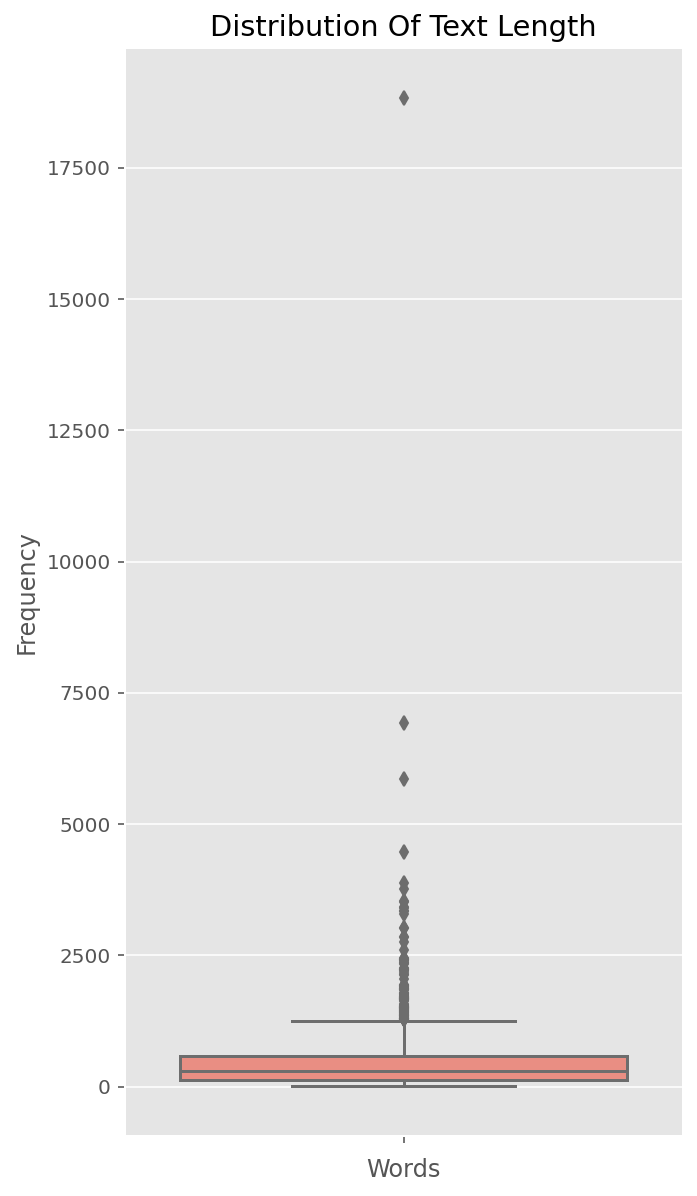

In [12]:
#boxplot for viewing outliers
plt.figure(figsize = (5,10))
sns.boxplot(lengths, orient='vertical', color = 'salmon')

plt.title("Distribution Of Text Length")
plt.xlabel("Words")
plt.ylabel("Frequency");

In [13]:
#searching for the outlier
mask = (red_data['data'].str.len() > 17500)
red_data.loc[mask]

,data,label
1013,i watched the entire 12 film backlog of grudge...,0


In [14]:
#dropping outlier post
red_data.drop(index=1013, inplace=True)

<div class="alert alert-block alert-info">
<b>Outlier:</b> index 1013 belongs to a single horror post where the author has made a review of 12 grudge films. I will drop this row as its contributions for text will only be limited to one doc. 
</div>

In [15]:
#generating a new list of text lengths for plotting
lengths = [len(text) for text in red_data["data"]]

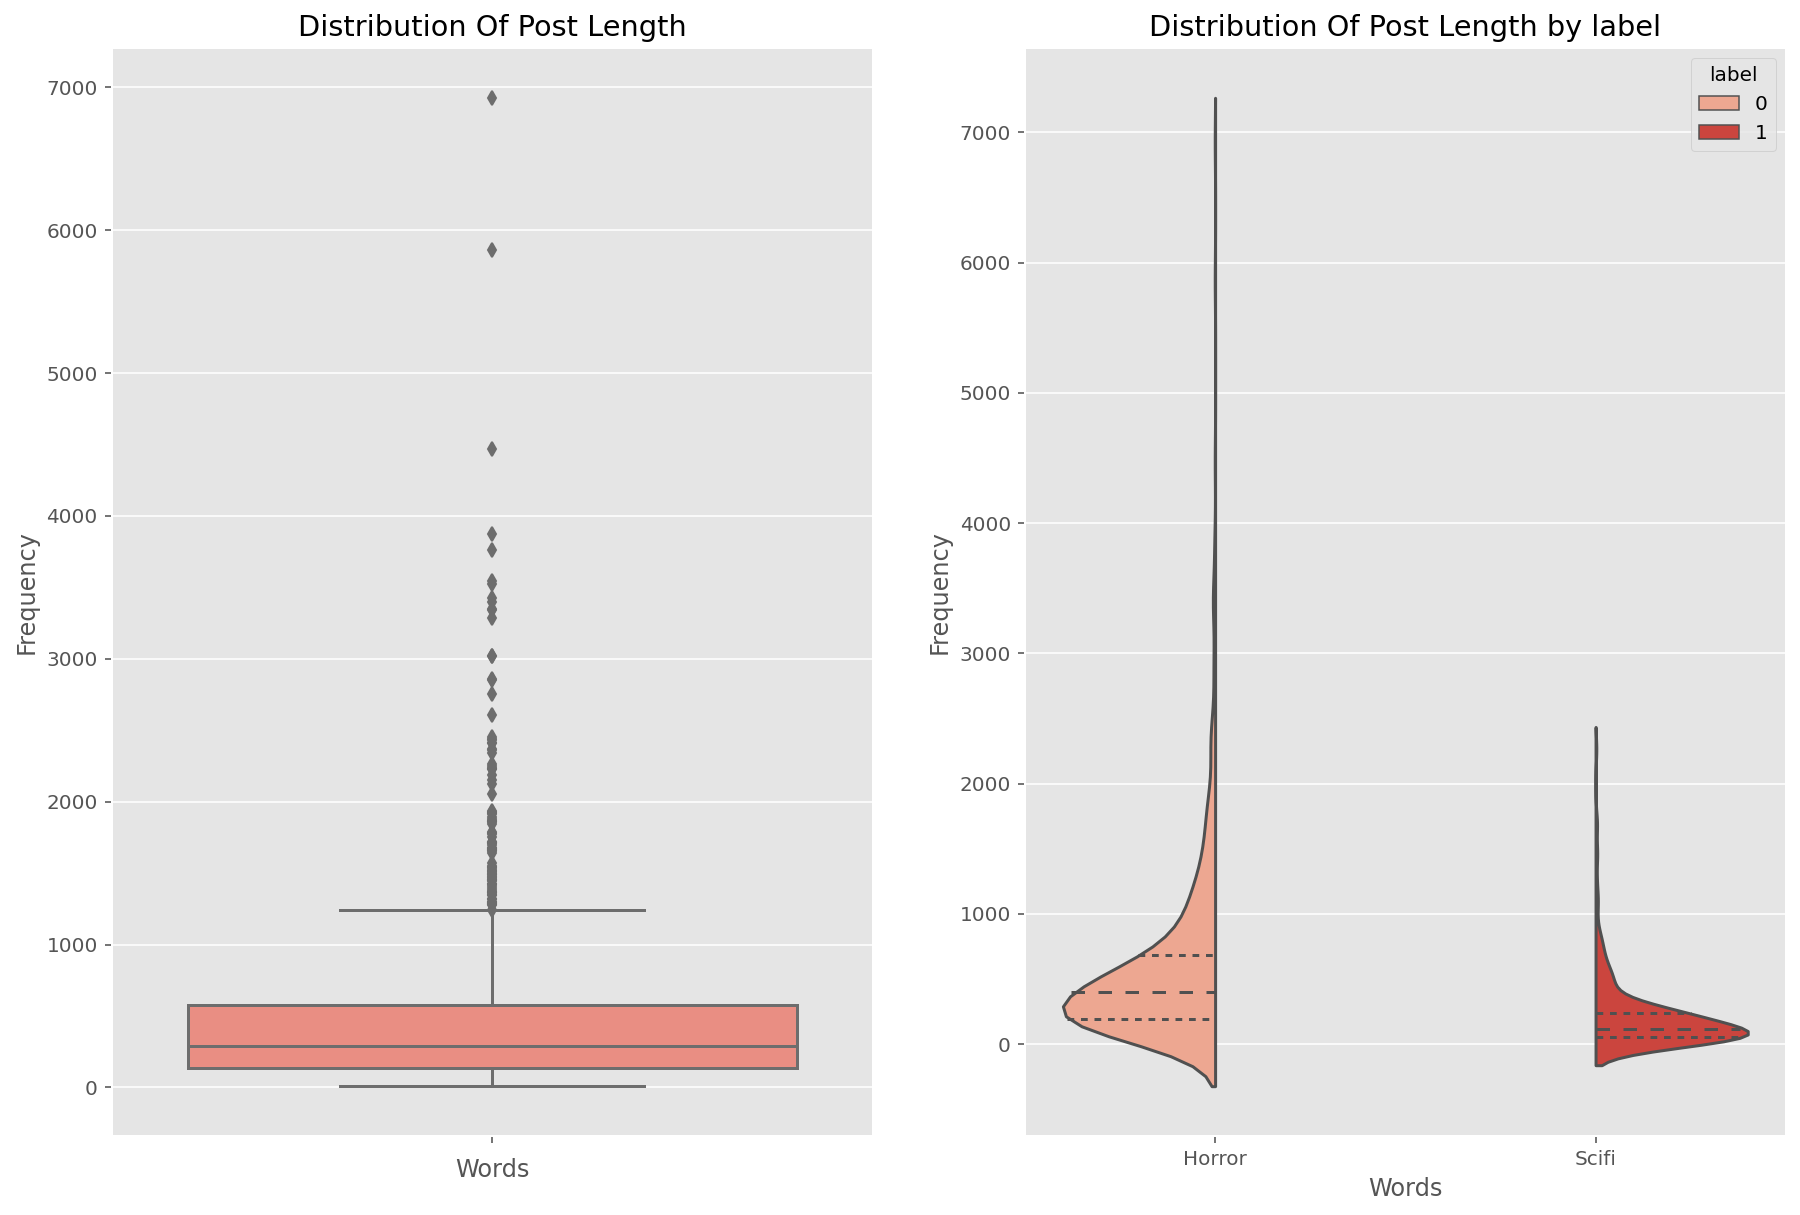

In [16]:
#plots to view distribution

plt.figure(figsize = (15,10))

plt.subplot(121)
sns.boxplot(lengths, orient='vertical', color='salmon')
plt.title("Distribution Of Post Length")
plt.xlabel("Words")
plt.ylabel("Frequency");

plt.subplot(122)
sns.violinplot('label',lengths, hue="label", alpha=0.6,
               palette='Reds', split=True, orient='vetical', data=red_data, inner="quart")
plt.title("Distribution Of Post Length by label")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(np.arange(2), ('Horror', 'Scifi'));



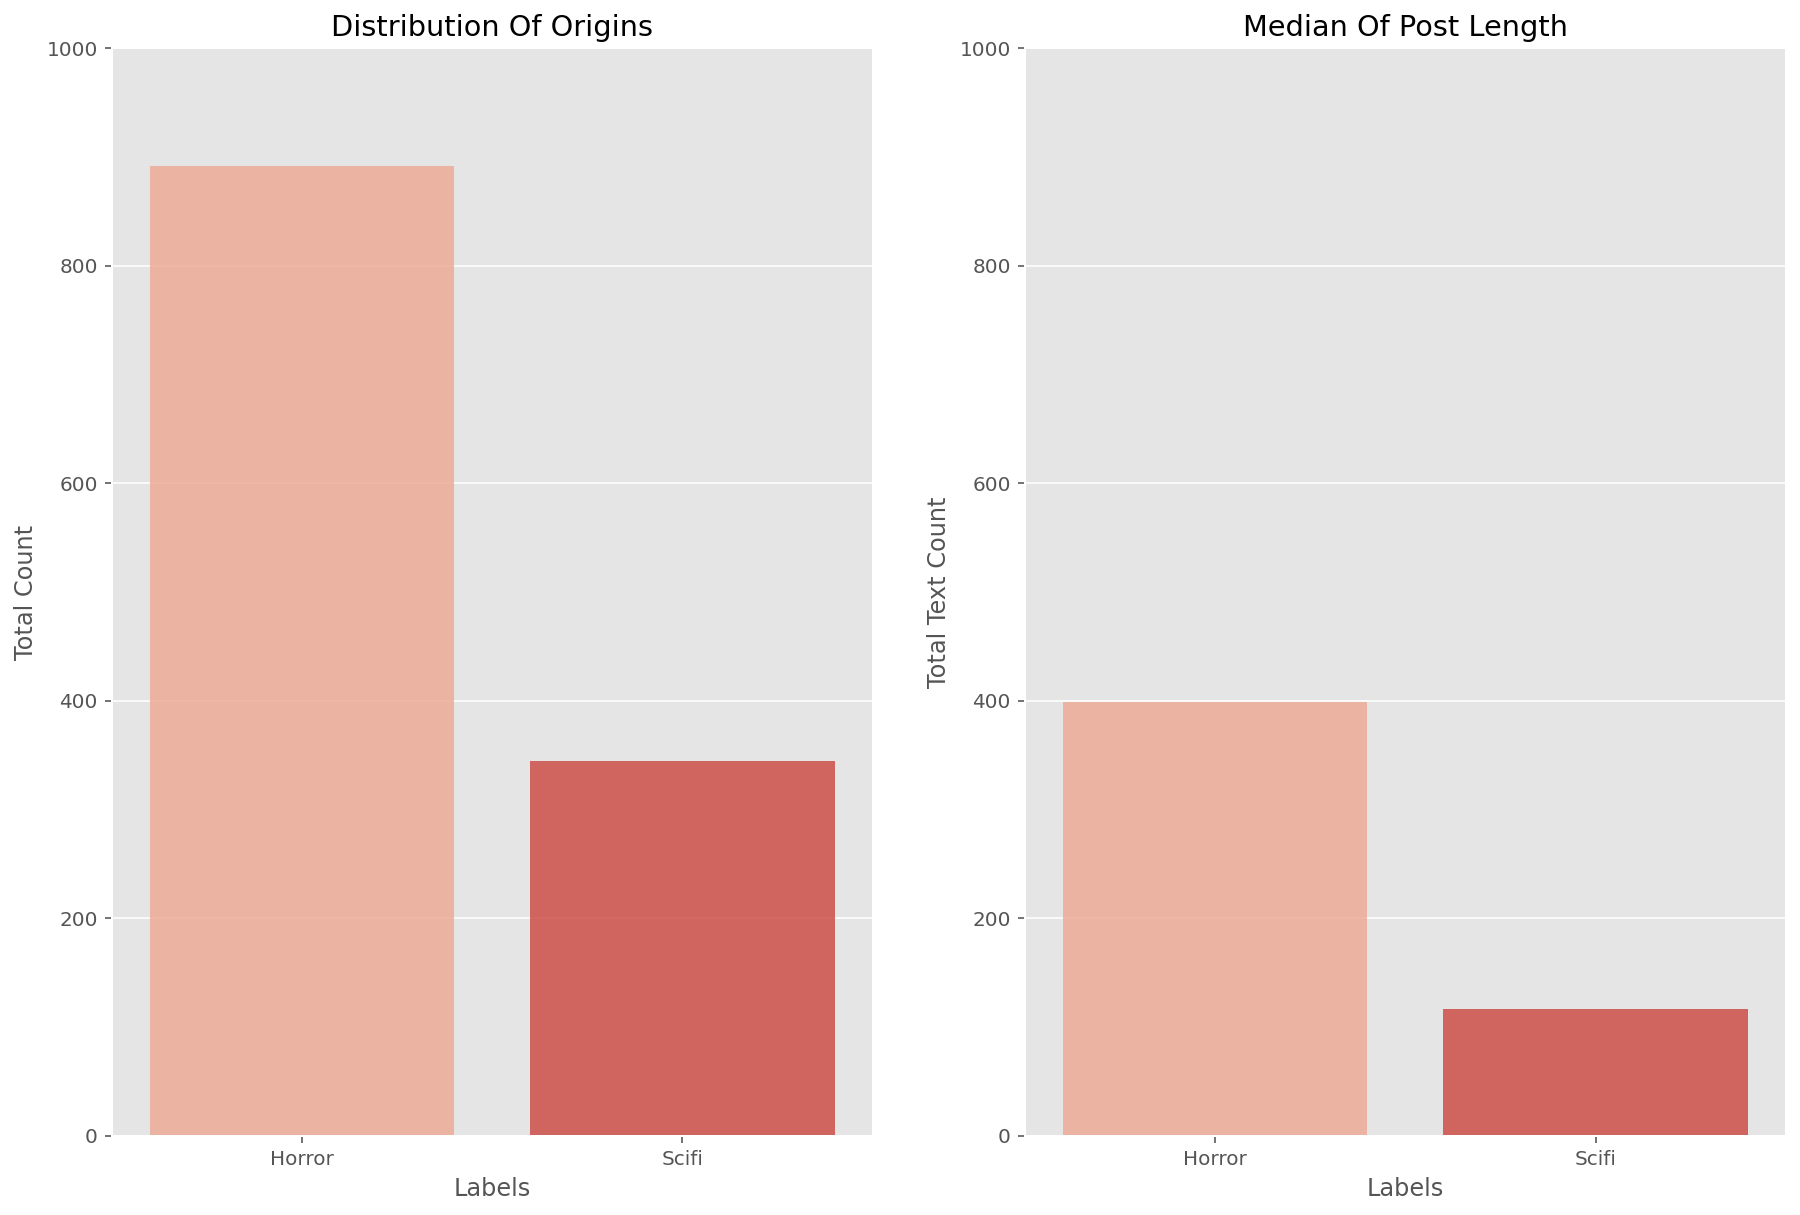

In [52]:
#plotting to see counts and median of post by subreddit
plt.figure(figsize = (15,10))


plt.subplot(121)
sns.countplot(red_data.label, palette="Reds", alpha=0.8)
plt.title("Distribution Of Origins")
plt.xlabel("Labels")
plt.ylabel("Total Count")
plt.xticks(np.arange(2), ('Horror', 'Scifi'));
plt.yticks(np.arange(0,1200,200))

plt.subplot(122)
sns.barplot(red_data.label,lengths, palette="Reds", alpha=.8, estimator=np.median, ci=None)
plt.title("Median Of Post Length")
plt.xlabel("Labels")
plt.ylabel("Total Text Count")
plt.xticks(np.arange(2), ('Horror', 'Scifi'))
plt.yticks(np.arange(0,1200,200));

 <div class="alert alert-block alert-info">
<b>Final view:</b>
        
- There is a total of 1238 post: 893 belonging to Horror and 345 belonging to Scifi. This presents an issue of imbalanced data. We can mediate this by avoiding models and scoring methods which are not favourable towards imbalanced data.
    
- An outlier was found and removed, there are still many posts outside the standard deviation range but they fall within reasonable limits and will not be removed. 
    
- We can see that Horror post have got greater length as well as median and has a longer tail ( greater spread) in its distribution, suggesting lengthier conversations within that subreddit group. 


With the information collected, it seems that we do have enough data to go onto preprocessing for the model. However we do have to get to Vectorisation to be able to see the quality of words left in the bag. 
    

</div>

***

## 2.2 Preprocessing



<b>2.2.1 Normalizing with movie_cleaner function:</b>
- removing all "http: .... " code
- lower-casing for all words
- removing emoji
- removing punctuations
- removing 'none'
- removing stop words
- removing all 4 digit numbers, (1965, 2001 etc)
> note: most data include the movie made year into their data, this should not be included in our classification data. 



<b>2.2.2 Normalizing with lemmatization and stemming:</b>
- shorten words to their root stems
- need to try both to see which is better for our model



<b>2.2.3 Vectorization:</b>
- Stop Words
- Exploration of Countvectorization
- Exploration of Countvectorization


- Back to: [2.0 EDA & Data Preprocessing](#2.0-EDA-&-Data-Preprocessing)
- Go to [Defined Functions](#Defined-Functions:)


***

### 2.2.1 Normalizing

In [18]:
#replacing foreign character
red_data['data'].replace({'明日战记': ''}, inplace=True, regex=True)

In [19]:
#cleaning movie data for next steps
red_data['data'] = [movie_cleaner(line) for line in red_data['data']]

In [20]:
#change data to type: str
red_data['data'] = red_data['data'].astype(str)

***

### 2.2.2 Stemming & Lemmatization

In [21]:
#instantiate Stemmer
stemmer = PorterStemmer()
#stemming into new column

red_data['stemmed']= [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in red_data['data']]

In [22]:
#instntiate Lemmatizer
lemmatizer = WordNetLemmatizer()
#lemming into new column
red_data['lemmatized']= [" ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")]) for sentence in red_data['data']]

In [23]:
#view data
red_data.head()

,data,label,stemmed,lemmatized
0,earth vs flying saucers movie trailer plot ext...,1,earth vs fli saucer movi trailer plot extrater...,earth v flying saucer movie trailer plot extra...
1,lives movie trailer plot epidemic mutant monst...,1,live movi trailer plot epidem mutant monster b...,life movie trailer plot epidemic mutant monste...
2,dredd good scifi movie,1,dredd good scifi movi,dredd good scifi movie
3,unearthly movie trailer plot mad doctor uses p...,1,unearthli movi trailer plot mad doctor use pat...,unearthly movie trailer plot mad doctor us pat...
4,scifi short film c600,1,scifi short film c600,scifi short film c600


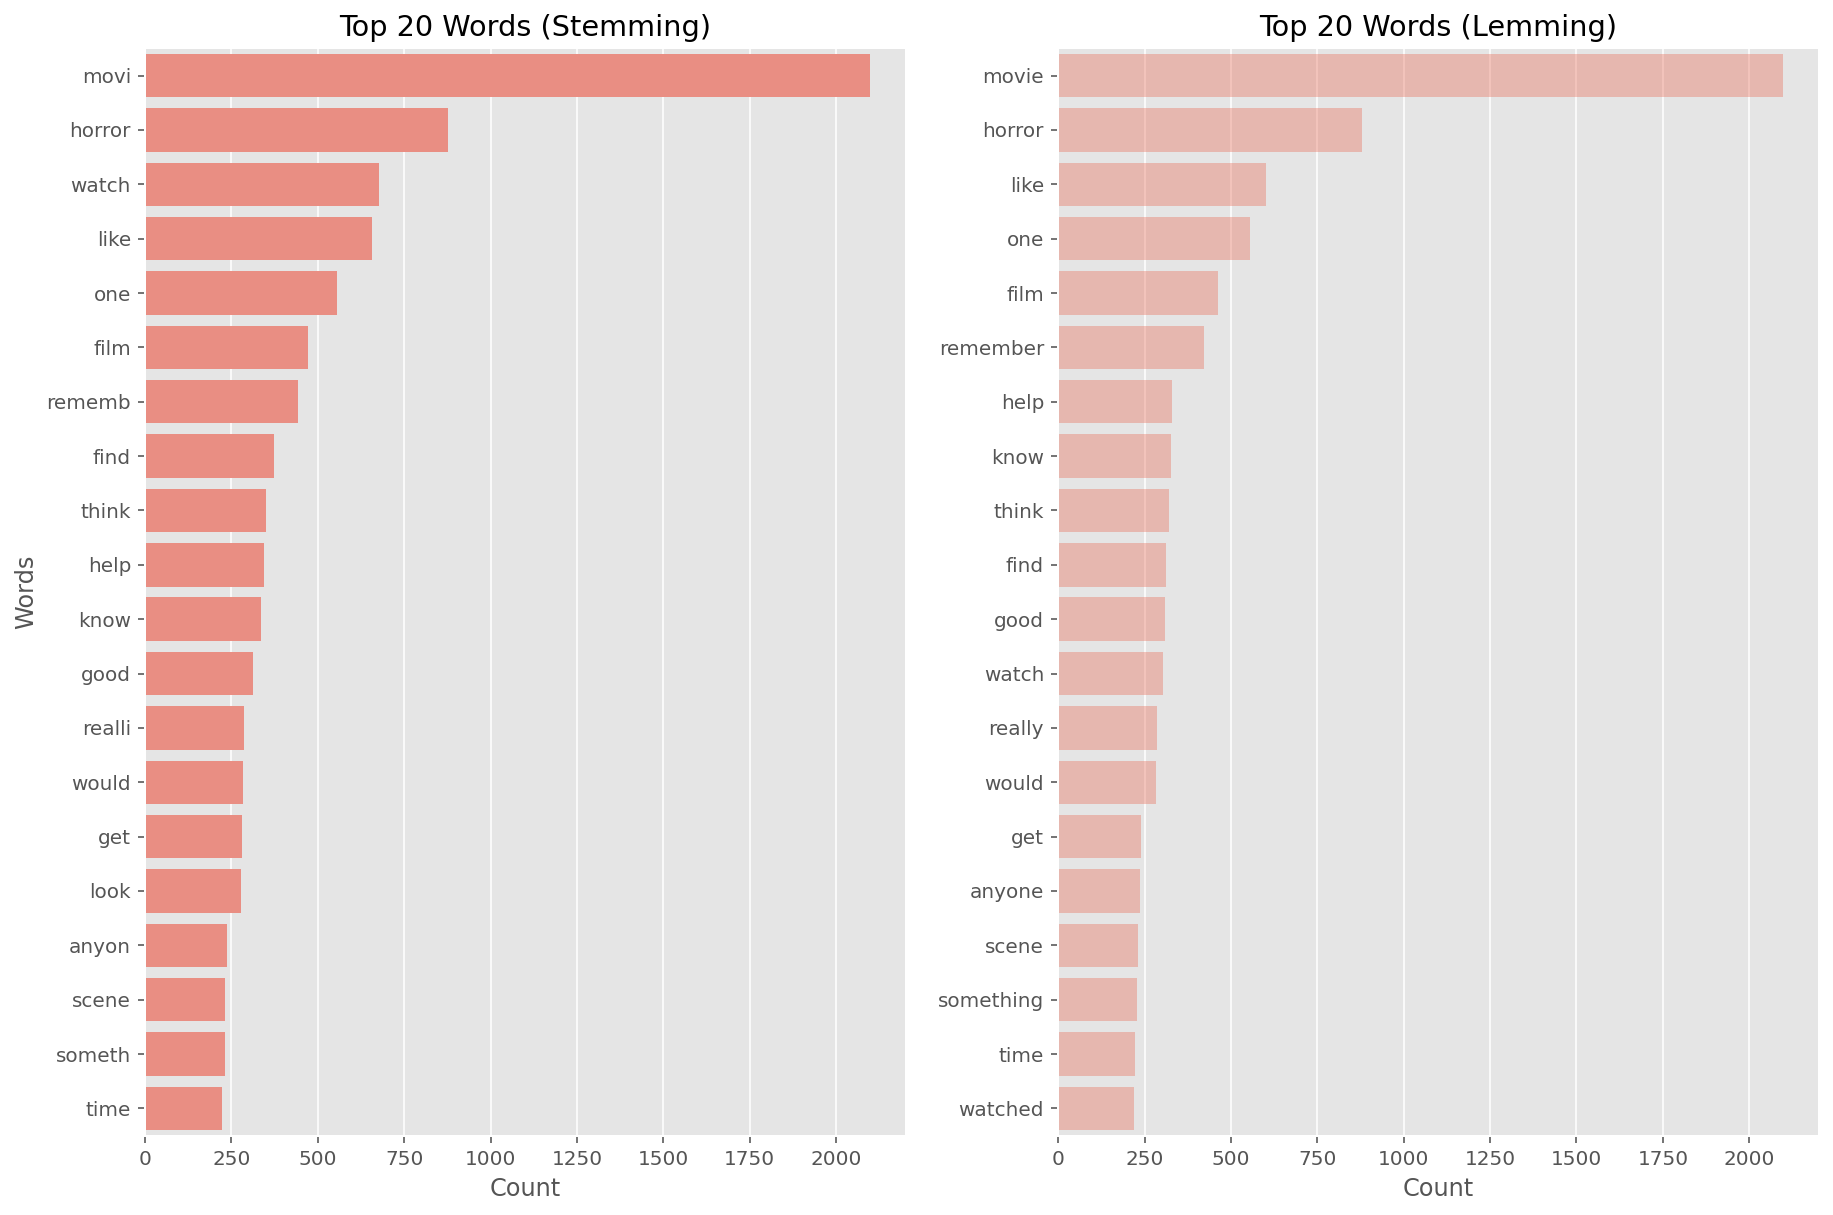

In [24]:
#visualising Stemming and Lemming

#getting bag of words for stemming
bow_stem = {}
for sentence in red_data['stemmed']:
    for word in sentence.split():
        if word in bow_stem:
            bow_stem[word] +=1
        else:
            bow_stem[word]= 1
            
            
#getting bag of words for lemming            
bow_lem = {}
for sentence in red_data['lemmatized']:
    for word in sentence.split():
        if word in bow_lem:
            bow_lem[word] +=1
        else:
            bow_lem[word]= 1



#converting into df for easy visualisation
bow_stem = pd.DataFrame(bow_stem.items())
bow_lem = pd.DataFrame(bow_lem.items())

# bow_stem = pd.DataFrame([bow_stem], index=True).T
# bow_lem = pd.DataFrame([bow_lem], index=True).T

bow_stem_20 = bow_stem.sort_values(1,ascending = False).head(20)
bow_lem_20 = bow_lem.sort_values(1,ascending = False).head(20)

plt.figure(figsize = (15,10))


plt.subplot(121)
sns.barplot(1,0, data=bow_stem_20, color="salmon", alpha=1, orient='horizontal')
plt.title("Top 20 Words (Stemming)")
plt.xlabel("Count")
plt.ylabel("Words")


plt.subplot(122)
sns.barplot(1,0, data=bow_lem_20, color="tomato", alpha=0.4, orient='horizontal')
plt.title("Top 20 Words (Lemming)")
plt.xlabel("Count")
plt.ylabel("");


<div class="alert alert-block alert-info">
<b>Stemming:</b> 
    
    
In hindsight, I have chosen stemming over leamming because it is able to get the root word over more instances of base words. Where in lemming, I find residuals of base words which did not get 'caught', leading to more work with filtering. 
    
> For example, 'watch' is stemming's top 3, but only appears in top 12 in lemming because lemming still sees 'watched' as another word in top 20. 
    
    
These top 20 most frequent words will also be added into the stop words list
</div>

In [25]:
#dropping original and lemmatized columns and saving into csv
red_data.drop('lemmatized', inplace=True, axis=1)
red_data.drop('data', inplace=True, axis=1)

red_data.to_csv('../datasets/stem_data.csv', index=False)

***

### 2.2.3 Stop Words (Additions)

In [26]:
stop_list=['movi', 'rememb', 'anyon', 'realli', 'seen', 'recommend', 'get',
           'someth', 'suggest', 'tri', 'want', 'pleas', 'thing', 'also', 'horror',
           'scifi', 'like', 'film', 'find', 'help', 'think', 'look', 'would',
           'trailer', 'plot', 'short', 'review', 'time', 'one', 'know', 'scene',
           'watch', 'name', 'year', 'good', 'thank', 'netflix', 'favorit', 'need',
           'end', 'charact', 'much', 'start', 'first', 'titl', 'thought' ]



stops = stopwords.words('english')
stops = stops + stop_list

stops = set(stops)
print(stops)

{'thank', 'favorit', 'not', 'if', 'also', 'end', 'i', 'get', 'rememb', 'he', 'name', 'o', 'am', 'up', "weren't", 'above', 'plot', 'we', 'the', 'now', 'there', 'look', 'by', 'whom', 'couldn', "shan't", 'll', "couldn't", 'my', 'between', 'some', 'shouldn', 'here', 'its', 'because', 'charact', 'any', 'who', 'titl', 'trailer', 'into', 'thought', 'after', "you're", 'to', "aren't", 'while', 'on', 'how', 'scifi', 'him', 'realli', 'recommend', 'further', 'their', 'so', 'me', 'watch', 'an', 'once', 'like', 'been', 'over', "it's", "mustn't", "hasn't", 'same', "that'll", 'off', 'pleas', 'all', 'isn', 'of', 'doesn', 'no', 'hers', 'at', 'tri', 'a', 'nor', 'being', 'd', 'this', 'your', 'through', "haven't", 'know', 'find', "shouldn't", 'most', "don't", 'movi', 'myself', 'but', 'under', 'thing', 'time', 'someth', 'aren', 'before', 're', 'did', 'themselves', 'with', 'review', 'much', 'below', 'you', 'can', 'ours', 'about', "you'll", 'weren', 'won', 'from', 'they', 'do', 'which', 'doing', 'netflix', 'd

<div class="alert alert-block alert-info">
<b>Stop words:</b> Nltk's original list of stop words has been run while normalising. I have included more stop words from the top 20 words, as well as additional stop words for <b>feature engineering</b>.
    
These stop words will be filtered out during the vectorizing stage, where I will make use of its stopwords fucntion to do the second filter. 
    
</div>

***

### 2.2.4 Vectorization

#### CountVectorizer

In [27]:
#read in stemmed data
norm_data = pd.read_csv('../datasets/stem_data.csv')

In [28]:
#view data
norm_data.head()

,label,stemmed
0,1,earth vs fli saucer movi trailer plot extrater...
1,1,live movi trailer plot epidem mutant monster b...
2,1,dredd good scifi movi
3,1,unearthli movi trailer plot mad doctor use pat...
4,1,scifi short film c600


In [29]:
#CountVectorizer

#instatiate Cvec
cvec = CountVectorizer(max_features=5000, lowercase=False, stop_words = stops)

#fit and transform data set
cvec_data_features = cvec.fit_transform(norm_data['stemmed'])

#converting the result to a DataFrame.
cvec_X_df = pd.DataFrame(cvec_data_features.todense(),columns=cvec.get_feature_names())

In [30]:
#view data
cvec_X_df.head()

,000,02,05,10,100,101,104,11,12,13,...,zellweg,zellwegg,zero,zeta,zombi,zombieland,zone,zoom,zound,zugarramurdi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#check the length of our data that is in a vectorized state
len(cvec.get_feature_names())

5000

In [32]:
#most frequent words
word_counts = cvec_X_df.sum(axis=0)
print(len(word_counts))

word_counts.sort_values(ascending = False).head(20)

5000


guy      195
peopl    184
love     177
go       176
well     176
girl     174
make     172
see      172
feel     157
scari    153
scare    146
kill     146
hous     145
lot      141
could    133
even     133
come     131
made     130
saw      129
way      128
dtype: int64

In [33]:
names = ['Horror', 'Scifi']
cvec_y_df = norm_data['label']
# Lets look through some of the categories common words

for i in range(2):
    common_words = []
    word_count = cvec_X_df[cvec_y_df==i].sum(axis=0)
    print (names[i], "most common words")
    if i == 0:
        horror_text_cvec = word_count.sort_values(ascending = False).head(30)
    else:
        scifi_text_cvec = word_count.sort_values(ascending = False).head(30)
    cw = word_count.sort_values(ascending = False).head(20)
    print (cw)
    common_words.extend(cw.index)
    print
    
    

Horror most common words
guy      187
girl     171
well     167
see      165
go       163
love     163
peopl    161
make     159
feel     156
scari    153
scare    144
hous     144
lot      128
kill     124
way      123
even     122
saw      118
could    117
stori    116
say      115
dtype: int64
Scifi most common words
alien        75
earth        43
space        34
man          30
ship         27
star         26
monster      26
planet       25
war          25
peopl        23
kill         22
human        20
world        18
old          17
new          17
come         17
made         16
group        16
two          16
scientist    16
dtype: int64


In [34]:
#saving Cvec data
cvec_X_df.to_csv('../datasets/cvec_x_data.csv', index=False)

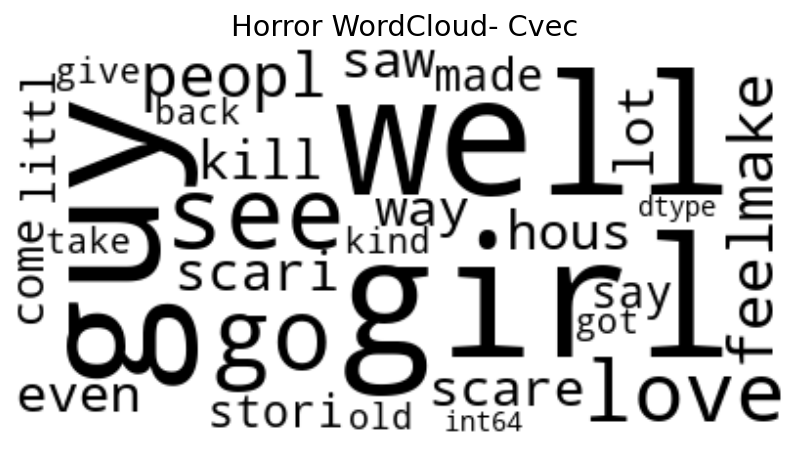

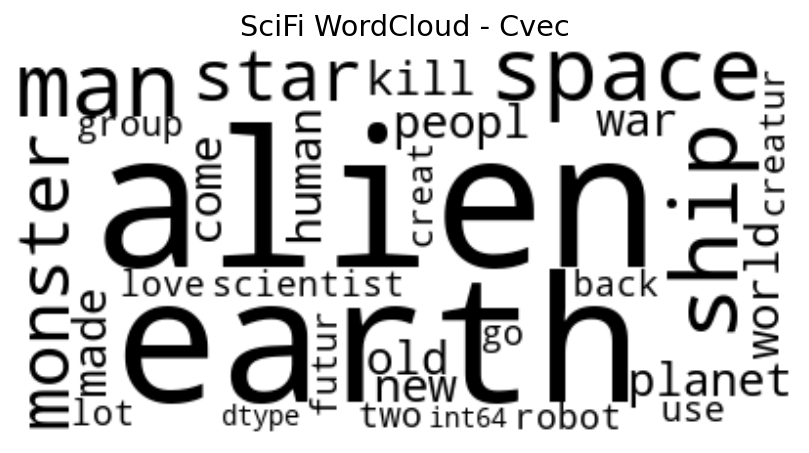

In [35]:

# Generate horror word cloud image
h_mask = np.array(Image.open("../images/03_horror_mask.png"))
wordcloud_horror = WordCloud(background_color="white", mode="RGBA").generate(str(horror_text_cvec))
image_colors = ImageColorGenerator(h_mask)
plt.figure(figsize=[7,7])
plt.title('Horror WordCloud- Cvec')
plt.imshow(wordcloud_horror.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# Generate a word cloud image
s_mask = np.array(Image.open("../images/03_scifi_mask.png"))
wordcloud_scifi = WordCloud(background_color="white", mode="RGBA").generate(str(scifi_text_cvec))
image_colors = ImageColorGenerator(s_mask)
plt.figure(figsize=[7,7])
plt.title('SciFi WordCloud - Cvec')
plt.imshow(wordcloud_scifi.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off");

#note: WordCloud mask did not produce an image as intended, 
#but remains as i'm using it to set colour. 

***

#### TF-IDF

In [36]:
# TF-IDF

#instatiate Cvec
tvec = TfidfVectorizer(max_features=5000, stop_words = stops)

# #fit and transform train set
# train_data_features = cvec.fit_transform(X_train)
# test_data_features = cvec.fit(X_test)

#fit and transform data set
tvec_data_features = tvec.fit_transform(norm_data['stemmed'])

#converting the result to a DataFrame.
tvec_X_df = pd.DataFrame(tvec_data_features.toarray(),columns=tvec.get_feature_names())

In [37]:
#view data
tvec_X_df.head()

,000,02,05,10,100,101,104,11,12,13,...,zellweg,zellwegg,zero,zeta,zombi,zombieland,zone,zoom,zound,zugarramurdi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#most frequent words
word_counts = tvec_X_df.sum(axis=0)
print(len(word_counts))

word_counts.sort_values(ascending = False).head(20)

5000


guy        19.195812
scari      18.738546
love       17.313390
scare      15.397379
alien      15.304255
girl       15.226206
peopl      14.926335
see        14.478045
go         13.858685
hous       13.592011
lot        13.292641
make       13.082574
monster    12.705700
well       12.532820
feel       12.505415
saw        12.433208
best       12.362733
new        12.344891
kill       11.936478
man        11.479569
dtype: float64

In [39]:
names = ['Horror', 'Scifi']
tvec_y_df = norm_data['label']
# Lets look through some of the categories common words

for i in range(2):
    common_words = []
    word_count = tvec_X_df[tvec_y_df==i].sum(axis=0)
    print (names[i], "most common words")
    if i == 0:
        horror_text_tvec = word_count.sort_values(ascending = False).head(30)
    else:
        scifi_text_tvec = word_count.sort_values(ascending = False).head(30)    
    
    cw = word_count.sort_values(ascending = False).head(20)
    print (cw)
    common_words.extend(cw.index)
    print

Horror most common words
scari     18.738546
guy       18.404939
scare     15.128913
love      14.847831
girl      14.836162
see       13.699590
hous      13.377551
go        12.604015
peopl     12.557869
feel      12.423498
make      11.886743
well      11.752280
lot       11.675020
best      11.201181
saw       11.122420
give      10.462182
got       10.323939
friend    10.029583
night      9.868660
littl      9.836892
dtype: float64
Scifi most common words
alien        11.114493
earth         7.404438
space         6.356837
war           5.995177
star          5.201436
man           4.739142
planet        4.372118
ship          4.084231
scientist     3.423751
monster       3.391943
robot         3.315022
human         3.204689
world         3.022167
creatur       2.984816
action        2.963636
land          2.878761
fiction       2.804606
new           2.802989
mar           2.722184
arriv         2.639139
dtype: float64


In [40]:
#saving Tvec data
tvec_X_df.to_csv('../datasets/tvec_x_data.csv', index=False)

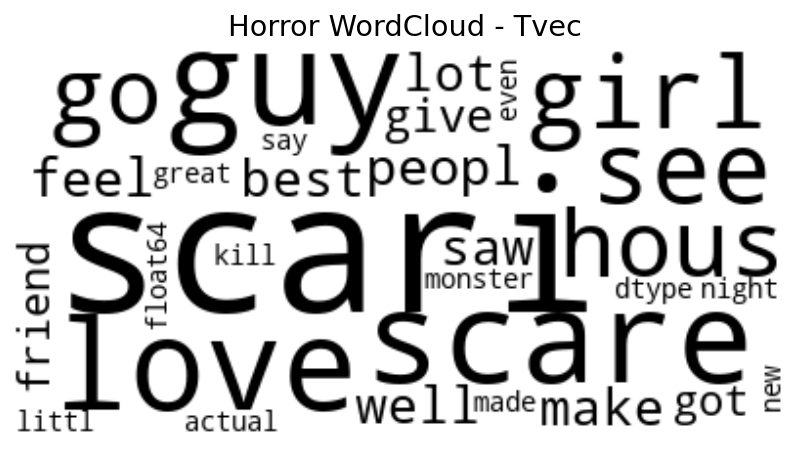

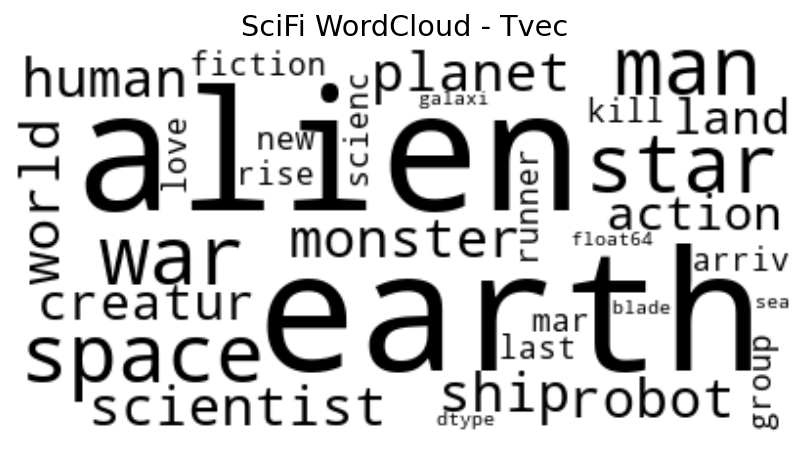

In [41]:
# Generate horror word cloud image
h_mask = np.array(Image.open("../images/03_horror_mask.png"))
wordcloud_horror = WordCloud(background_color="white", mode="RGBA").generate(str(horror_text_tvec))
image_colors = ImageColorGenerator(h_mask)
plt.figure(figsize=[7,7])
plt.title('Horror WordCloud - Tvec')
plt.imshow(wordcloud_horror.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# Generate a word cloud image
s_mask = np.array(Image.open("../images/03_scifi_mask.png"))
wordcloud_scifi = WordCloud(background_color="white", mode="RGBA").generate(str(scifi_text_tvec))
image_colors = ImageColorGenerator(s_mask)
plt.figure(figsize=[7,7])
plt.title('SciFi WordCloud - Tvec')
plt.imshow(wordcloud_scifi.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off");

#note: WordCloud mask did not produce an image as intended, 
#but remains as i'm using it to set colour. 

***

<div class="alert alert-block alert-info">
<b>Quality of words:</b> 
    
I am very satisfied with the quality of words, especially those coming from the SciFi post. We see that the horror post have more general words and some horror associated words; whereelse the SciFi post have pretty genre distinct words. This should have a positive impact the quality of the classifier predictions for SciFi. 
    
</div>

- Back to: [2.0 EDA & Data Preprocessing](#2.0-EDA-&-Data-Preprocessing)
- Go to [Defined Functions](#Defined-Functions:)

Jump to:
- [1.0 Data Collection and Cleaning](01_data_collection_&_cleaning.ipynb)
<!-- - [2.0 EDA & Data Preprocessing](02_eda_&_data_processing.ipynb) -->
- [3.0 Model Building](03_model_building.ipynb)
- [4.0 Reddit Classification Report](04_reddit_classification_report.ipynb)

***